# Artigo 7 - Filtros Colaborativos aplicado ao dataset *Book-Crossing: User review ratings*

## Objetivo

O objetivo deste presente trabalho é criar um modelo de recomendação de livros usando o dataset *Book-Crossing: User review ratings* aplicando filtros colaborativos aprendido na lição 7 do *fast.ai*.

## Autor

- Levi de Oliveira Queiroz 170108341
- GitHub: LeviQ27
- Kaggle User: lqueiroz27
- HuggingFace User: L27Queiroz

## Referência

- Notebook Kaggle Utilizado como referência para produzir o presente artigo: https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive/notebook#Deep-Learning-for-Collaborative-Filtering

- Lição 07 *Collaborative filtering* do *fastai*: https://course.fast.ai/Lessons/lesson7.html

- O Dataset *Book-Crossing: User review ratings* utilizado: https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset

## Desenvolvimento

Comecei importando os módulos necessários para lidar com questões de filtragem colaborativa e com dados tabulares, também coloquei, assim como o Jeremy, uma semente 42 para geração de números aleatórios:

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

Feito a importação, comecei a verificar o dado escolhido para este presente trabalho. No local do dado é dito que contém 278,858 usuários (anonimizado mas com informações demográficas) provendo 1,149,780 classificações (explicita ou implicita) de 271,379 livros. Assim, fiz a leitura do arquivo csv *BX-Book-Ratings.csv*:

In [2]:
path = Path('../input/bookcrossing-dataset')
ratings = pd.read_csv(path/'Book reviews/Book reviews/BX-Book-Ratings.csv', encoding='latin-1', delimiter=';', header=None, usecols=(0,1,2), names=('user_id','isbn','rating'), low_memory=False)
ratings = ratings.drop(0)
ratings = ratings.reset_index(drop=True)
ratings.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Uma observação sobre o que foi feito no código: 
Quando é feito a leituros do arquivo csv *BX-Book-Ratings.csv* pelo `pd.read_csv()` apresenta um erro de leitura *utf-8*, para resolver apliquei como parâmetro `encoding='latin-1'`, que simplismente altera a linguagem de codificação de *utf-8* para *latin-1*. Logo após rodar novamente tive o erro de divisão de colunas, que por padrão, o pandas entende que `,` é um separador de colunas, por isso passei como parâmetro `delimiter=';'` que simplesmente altera o padrão de entendimento de separador do pandas de `,` para `;`. Em seguida tirei os título das colunas usando o parâmetro `header=None`, porém percebi que ao fazer isso a linha *0* era colocada com os títulos das colunas, para resolver isso apliquei a função de remoção da linha *0* usando `drop()` e resetei o index das linhas usando a função `reset_index(drop=True)`, de modo que o index das linhas é resetado e os títulos foram eliminados. Sem os título e seguindo as instruções do Jeremy, separei as colunas *0*, *1* e *2* com `usecols` e inseri os nomes das colunas usando `names`. A utilização do parâmetro `low_memory=False` foi feito por uma sugestão no Kaggle ao rodar o código sem esse parâmetro, pois as colunas *0* e *2* tem tipos misturados, e ao rodar usando esse parâmetro não retornou avisos.

Em seguida, foi feito as etapas para criar o DataLoaders, começando por:

Fiz a leitura do arquivo *BX_Books.csv* para obter os nomes e números *ISBN* de cada um deles,

In [3]:
books = pd.read_csv(path/'Book reviews/Book reviews/BX_Books.csv', encoding='latin-1', delimiter=';', header=None, low_memory=False, usecols=(0,1), names=('isbn','title'))
books = books.drop(0)
books = books.reset_index(drop=True)
books.head()

,isbn,title
0,0195153448,Classical Mythology
1,0002005018,Clara Callan
2,0060973129,Decision in Normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It
4,0393045218,The Mummies of Urumchi


Assim como anteriormente, tratei os dados contidos em `BX_Books.csv` com tratei para criar a variável `ratings`. 

Como instruido na aula do Jeremy, juntei a tabela `ratings` com a tabela `books`: 

In [4]:
ratings = ratings.merge(books)
ratings['rating'] = ratings['rating'].astype('int')
ratings.head()

,user_id,isbn,rating,title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


Agora, criei um objeto `DataLoaders` dessa tabela. Por padrão,as colunas *user_id*, *isbn* e *rating* serão utilizadas para produzir o objeto. Assim, mudei o valor de `item_name` no nosso caso para usar os títulos em vez dos IDs:

In [5]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=824288)
dls.show_batch()

,user_id,title,rating
0,143253,The Cunning Man: A Novel,0
1,115490,Briar Rose,0
2,76352,Lake News,0
3,17190,"Left Behind Graphic Novel (Book 1, Vol.3 )",7
4,275970,The New Russians: Updated to Include the Failed Coup,0
5,3363,Step-Ball-Change,0
6,242824,"Charmed Circle (American Romance, No 301)",0
7,269136,Penguin Readers Level 2: of Mice and Men (Penguin Readers),0
8,258907,"The Metamorphosis, In the Penal Colony, and Other Stories",0
9,169357,Writ of Execution,9


Descrevendo um pouco sobre o código, foi cirado o objeto `dls` que contém os dados necessários para treinar e validar o modelo de filtragem colaborativa. `CollabDataLoaders` é uma classe fornecida pelo fastai qua ajuda na criação dos `DataLoaders` que são responsáveis por fornecer os lotes de dados para o treinamento do modelo. O método estático `from_df` permite criar um objeto a partir de `ratings`. O parâmetro `item_name='title'` indica a coluna de `ratings` que contém os nomes dos itens, é necessário para que o modelo saiba como identificar cada item. O parâmetro `bs=824288` define o tamanho do lote usado durante o treinamento do modelo. O comando `dls.show_batch()` exibe uma amostra dos dados carregados nos `DataLoaders`.

Para representar filtragem colaborativa em PyTorch não posso apenas usar a representação apresentada diretamente, especialmente quando quero encaixar o framework deep learning que vou usar. Representei as tabelas de fatores latentes de livros e usuários como matrizes simples:

In [6]:
n_users = len(dls.classes['user_id'])
n_books = len(dls.classes['title'])
n_factors = 50

As variáveis `n_users` e `n_books` recebem o número de usuários e de livros no conjunto de dados. Isso pois foi utilizado a função `len()` para calcular o comprimento das colunas, selecionadas através de `dls.classes[coluna]`. Coloquei como *50* fatores latentes.

Agora como parte da lição 7, o Jeremy passa pela criação do produto escalar por etapas. No caso, em referência à lição 7 fiz uma função de produto escalar:

In [7]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 10)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.book_factors = Embedding(n_books, n_factors)
        self.book_bias = Embedding(n_books, 1)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        books = self.book_factors(x[:,1])
        res = (users * books).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.book_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

No código acima tenho a importação da classe `Module` do módulo `torch.nn` do PyTorch que é usada para definir modelos de aprendizagem de máquina, dela é fronecido funcionalidades e métodos comuns para criar e gerenciar modelos. Assim, criei a classe `DotProductBias`, com `__init__` sendo construtor da classe que inicia os atributos da classe e define as camadas e parâmetros necessários para o modelo, `n_users` é o número de usuários e `n_books` de livros do conjunto dados, `n_factors` ~e o número de fatores latentes a serem usados, no caso definir como 5, `y_range` é um intervalo de valores esperados para as previsôes do modelo. Para as partes usando o `Embedding` estou fazendo uma incorporação para representar os usuários e os livros, no caso de `*_factors` estou querendo usar a camada de incorporação para representar os usuários e livros, no caso de `*_bias`estou querendo representar o viés dos usuários e livros. Seguindo para `foward()` este metodo define a passagem direta do modelo, sendo *x* um tensor de entrada que contém os índices dos usuários e filme, `users` e `books` usam as camadas de incorporação para obter os fatores latentes correspodentes a cada um dele presente em `x[:,0]` e `x[:,1]`. Assim faço a some do produto escalar dos fatores latentes de `users` e `books` em `(users * books).sum(dim=1, keepdim=True)` ao longo da dimensão 1 `dim=1` e matenho as dimensões da matriz em `keepdim=True`. O resultado dessa soma é uma matriz de previsões parciais para cada par usuário-livro. Assim sigo para adicionar os viéses dos usuário e dos filme às previsões parcias, auxiliando as previsões de acordo com os padrões específicos de cada usuário e livro em `res += self.user_bias(x[:,0]) + self.book_bias(x[:,1])`. Com isso feito, dou um retorno da função `sigmoid_range` em que é aplicado uma função de ativação sigmoidal às previsões resultantes e aplica um redimensionamento linear para garantir que as previsões estejam dentro do intervalo definidao por `y_range`.

Agora treino o modelo aplicando o conceito de Decaimento por peso, que consiste em adicionar para a função de loss a soma de todos os pasos ao quadrado, para encorajar o pesos a serem o mais pequenos possíveis:

In [8]:
model = DotProductBias(n_users, n_books, n_factors)
learn_dot = Learner(dls, model, loss_func=MSELossFlat())
learn_dot.fit_one_cycle(5, 11e-3, wd=5)

epoch,train_loss,valid_loss,time
0,19.532913,19.532427,00:04
1,19.527033,19.394743,00:04
2,19.464888,19.244173,00:04
3,19.383923,19.132275,00:04
4,19.305305,19.086620,00:04


No código acima, criei uma instância do modelo `DotPRoductBias` com base no número de usuários, número de livros e 50 fatores latentes. Em seguida, ele cria um objeto `Learner` com base nos dados de treinamento, no modelo e a função de perda `MSELossFlat`. Depois disso apliquei o método `fit_one_cycle` para treinar o modelo por 5 épocas, com uma taxa de aprendizagem inicial de 11e-3 e uma peso de decaimento (weight decay) de 0.1. O peso de decaimento consiste em adicionar a função de loss a som de todos os pesos quadráticos, para que quando computo os gradientes, vai adicionar uma constribuição para eles em que vai encorajar os pesoas a serem os mais pequenos possíveis.

Agora para finalizar a parte do desenvolvimento do artigo e da produção do modelo, criei um modelo deep learning para a filtragem colaborativa. Para isso, comecei colocando na variável `embs` o retorno da recomendação da função do *fastai* `get_emb_sz` dá de tamanho de incorporação de matrizes para o dado que estou usando,

In [9]:
embs = get_emb_sz(dls)
embs

[(92108, 600), (241091, 600)]

Agora implemento essa classe:

In [10]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,11), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

A classe `CollabNN` implementa um modelo de filtragem colaborativa com redes neurais. Esse modelo é usado para fazer previsões ou recomendações com base em dados de usuários e itens, analisando como ele funciona tenho:

No método `__init__`, são definidos os atributos da classe. `user_sz` e `item_sz` são tuplas que contêm o número de usuários e itens no conjunto de dados, respectivamente, bem como a dimensão dos fatores latentes para usuários e itens. O intervalo `y_range` especifica os valores esperados das previsões do modelo, e `n_act` determina o número de neurônios na camada oculta da rede neural.

Em seguida, são criadas as camadas de incorporação (embedding) para representar os usuários e itens. A camada de incorporação para os usuários tem dimensão de acordo com `user_sz`, e a camada de incorporação para os itens tem dimensão de acordo com `item_sz`.

A rede neural é definida usando a classe `nn.Sequential`, que permite empilhar camadas sequencialmente. Ela consiste em uma camada linear de entrada, uma função de ativação `ReLU` e uma camada linear de saída. A camada linear de entrada recebe as representações concatenadas dos usuários e itens como entrada, enquanto a camada linear de saída produz uma única saída, que é a previsão final do modelo.

No método `forward`, o tensor de entrada *x* contém os índices dos usuários e itens. A partir desses índices, são obtidas as representações de incorporação dos usuários e itens correspondentes. Essas representações são então concatenadas ao longo da dimensão 1 para formar um único tensor de entrada para a rede neural.

Esse tensor é passado pelas camadas da rede neural definidas anteriormente, e a saída resultante é aplicada a uma função de ativação sigmoidal. Essa função sigmoidal garante que as previsões estejam dentro do intervalo especificado por `y_range`. Por fim, as previsões redimensionadas são retornadas como saída do método forward.

E assim, utilizo para criar o modelo e fazer o treino dele:

In [11]:
model = CollabNN(*embs)
learn_deep = Learner(dls, model, loss_func=MSELossFlat())
learn_deep.fit_one_cycle(5, 3e-5, wd=0.05)

epoch,train_loss,valid_loss,time
0,21.400429,21.416176,00:35
1,21.400284,21.414125,00:34
2,21.399372,21.411749,00:31
3,21.398333,21.409906,00:32
4,21.397482,21.409153,00:31


Essas linhas de código têm o objetivo de criar e treinar um modelo de filtragem colaborativa. Entendendo o que cada parte faz:

Na linha `model = CollabNN(*embs)`, um objeto chamado model é criado. Ele representa o modelo de filtragem colaborativa e utiliza as representações de incorporação dos usuários e itens, que estão armazenadas na variável embs. O desempacotamento `(*embs)` permite passar as representações corretas para o construtor da classe *CollabNN*, inicializando o modelo adequadamente.

Na linha `learn = Learner(dls, model, loss_func=MSELossFlat())`, um objeto chamado learn é criado. Ele representa o objeto de aprendizado (learner) responsável por treinar o modelo. O objeto dls contém o conjunto de dados de treinamento e validação. O modelo criado anteriormente (model) é passado como argumento, juntamente com a função de perda *MSELossFlat()*, que mede o erro quadrático médio entre as previsões do modelo e os rótulos reais.

Na linha `learn.fit_one_cycle(15, 10e-2, wd=0.01)`, o método `fit_one_cycle()` é chamado para treinar o modelo. Ele recebe três argumentos: o número de épocas de treinamento (15), a taxa de aprendizado (10e-2) e a força da regularização (0.01). Durante o treinamento, o modelo será ajustado aos dados em várias iterações (épocas) para fazer previsões mais precisas.

Feito isso, passei para a exportação do modelo para utilizá-lo no aplicativo do Hugging Face:

## Inferência

Após montar os modelos, fiz alguns testes para ver como reagiam ao pedido de recomendação de um usuário, mas também é interessante ver que parâmetros tem descoberto. O caminho mais fácill é pelo viés. Aqui os livros estão com os menores valores no vetor de viéses:

In [17]:
book_bias_dot = learn_dot.model.book_bias.weight.squeeze()
idxs = book_bias_dot.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Night Whispers',
 'Vector',
 'The Red Tent (Bestselling Backlist)',
 'Dragon Tears',
 'The Unlikely Spy']

No código acima tenho que a variável `book_bias_dot` recebe o vetor de viés dos livros que contem os menores pesos relacioandos as livros aprendido no modelo. Assim classifiquei os índices do vetor `book_bias_dot` em ordem crescente e usei a função `argsort()` para retornar os índices que ordenariam o vetor. Em seguida, selecionei os primerios cinco índices usando ` [:5]` e atribuí à variável `idxs`. Por fim imprimo uma lista dos cinco títulos de livros com os menores valores de viés usando `[dls.classes['title'][i] for i in idxs]`. 

Assim, também vou apresentar quais são os livros de maior viés:

In [22]:
idxs = book_bias_dot.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['The Summer They Came : A Novel',
 'Up In a Heaval : A Xanth Novel (Xanth)',
 'Fallen Host',
 "Robert Crowther's Amazing Pop-Up House of Inventions: Hundreds of Fabulous Facts About Where You Live",
 'The Last Battle']

Mas aqui vejo somente 5 livros que foram os de menores e maiores viés dentro do meu vetor de viés. Para ter uma melhor visualização apliquei o PCA (*principal component analisys*), para olhar que livros aparentam baseados nos dois componentes PCA mais fortes:

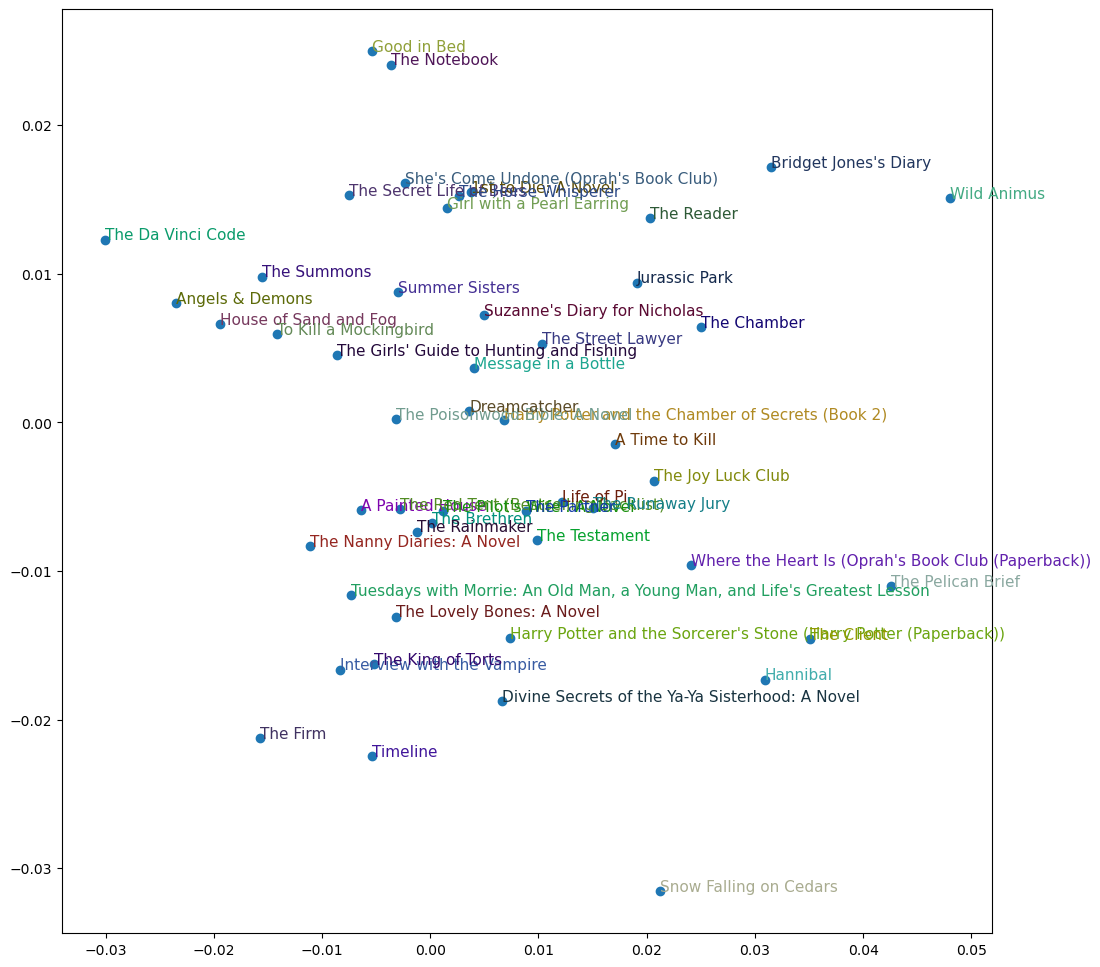

In [25]:
g = ratings.groupby('title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn_dot.dls.classes['title'].o2i[m] for m in top_books])
book_w = learn_dot.model.book_factors.weight[top_idxs].cpu().detach()
book_pca = book_w.pca(3)
fac0,fac1,fac2 = book_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Explicando o código linha por linha:

- `g = ratings.groupby('title')['rating'].count()`: Aqui, estou agrupando os dados de classificação (`ratings`) pelo título do livro e contando o número de avaliações para cada título. Isso cria uma série que mapeia cada título de livro para a contagem de avaliações.
- `top_books = g.sort_values(ascending=False).index.values[:1000]`: Nesta linha, estou classificando os títulos de livros com base na contagem de avaliações em ordem decrescente. `sort_values(ascending=False)` classifica os valores em ordem decrescente, e `index.values` retorna os títulos ordenados como uma matriz de valores. Em seguida, seleciono os primeiros 1000 títulos usando `[:1000]` e os atribui à variável `top_books`.
- `top_idxs = tensor([learn_dot.dls.classes['title'].o2i[m] for m in top_books])`: Aqui, estou mapeando os títulos dos livros (`top_books`) para os respectivos índices usando o dicionário `learn_dot.dls.classes['title'].o2i`. O loop `for` itera sobre cada título em `top_books`, obtém o índice correspondente usando `o2i[m]` e cria uma lista de índices. Essa lista é convertida em um tensor usando `tensor()` e armazenada na variável `top_idxs`.
- `book_w = learn_dot.model.book_factors.weight[top_idxs].cpu().detach()`: Nesta linha, estou acessando os vetores de incorporação dos livros (`book_factors`) do modelo `learn_dot`. Os vetores de incorporação correspondentes aos índices em `top_idxs` são selecionados usando a indexação `[top_idxs]`. Em seguida, você move os dados para a CPU usando `cpu()` e os detaca do grafo de computação usando `detach()`, armazenando-os na variável `book_w`.
- `book_pca = book_w.pca(3)`: Aqui, estou aplicando a análise de componentes principais (PCA) nos vetores de incorporação dos livros (`book_w`). O método `pca(3)` calcula as três primeiras componentes principais dos vetores de incorporação, e o resultado é armazenado na variável `book_pca`.
- `fac0, fac1, fac2 = book_pca.t()`: Nesta linha, estou transpondo a matriz resultante da análise de componentes principais (`book_pca`) usando o método `t()`. Em seguida, você atribui cada componente principal a uma variável separada: *fac0*, *fac1* e *fac2*.
- `idxs = list(range(50))`: Aqui, estou criando uma lista de números de 0 a 49 e atribuindo-a à variável `idxs`. Esses índices serão usados para selecionar uma amostra de 50 livros para visualização no gráfico de dispersão.
- `X = fac0[idxs] e Y = fac2[idxs]`: Essas linhas selecionam as coordenadas das componentes principais 0 e 2 para os índices especificados em `idxs`. As coordenadasdas componentes principais são armazenadas nas variáveis `X` e `Y`, respectivamente.
- `plt.figure(figsize=(12,12))`: Aqui, estou criando uma nova figura para o gráfico de dispersão com o tamanho de 12x12 polegadas.
- `plt.scatter(X, Y)`: Esta linha gera o gráfico de dispersão usando as coordenadas `X` e `Y` para plotar os pontos. Cada ponto representa um livro no espaço das componentes principais.
- `for i, x, y in zip(top_books[idxs], X, Y):`: Aqui, itero sobre os títulos dos livros (`top_books`) correspondentes aos índices `idxs`, juntamente com as coordenadas `X` e `Y`. O uso da função `zip()` combina os três iteráveis em tuplas.
- `plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)`: Essa linha adiciona um texto ao gráfico de dispersão para cada ponto. O texto consiste no título do livro (i) e é posicionado nas coordenadas (x, y). A cor do texto é escolhida aleatoriamente usando `np.random.rand(3)*0.7`, e o tamanho da fonte é definido como 11.
- `plt.show()` Essa linha exibe o gráfico de dispersão completo na interface de exibição.

Certo, com isso testo, achando pelo modelo, um livro e espero o retorno de qual livro se pareça com o livro que inseri:

In [37]:
books_factors_dot = learn_dot.model.book_factors.weight
idx = dls.classes['title'].o2i['The Summons']
distances = nn.CosineSimilarity(dim=1)(books_factors_dot, books_factors_dot[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Best Mounted Police Stories'

Em referencia ao grafico plotado, o output da linha anterior deveria ter retornando um livro ao redor do livro que escolhi para o teste, porém não ocorreu, isso pode se dar a vários fatores, o loss de treino e validação ficaram muito discrepantes e etc.

Assim, fiz o export do *modelo_deep* e o apliquei no aplicativo que se encontra no HuggingFacep App no link https://huggingface.co/spaces/L27Queiroz/BookRecomendations:

In [ ]:
learn_deep.export('model.pkl')

## Conclusão

Achei interessante construir um modelo de recomendação utilizando filtros colaborativos e também presenciei bastantes dificuldades com o dataset, tive problemas de linguagem *encoding*, a coluna de ratings estava vindo como objetos e o *DataLoader* só trabalhos com valores númericos, na hora de usar o modelo em produto escalar teve um momento em que fique 1 hora esperando o fazer o primeiro ciclo de treinamento, no HuggingFace App na hora de pedir para fazer a sugestão está dando error. Então finalizando, foi trabalhoso e divertido estudar sobre filtros colaborativos e gradientes descedentes.
